In [22]:
#https://drive.google.com/file/d/1_nVskrLN9GdflJbUJ-3poC-BvHWi-nq2/view?usp=sharing
#https://drive.google.com/file/d/1AdgjENltVqg8YJoI6C_62G2gevrzyC4s/view?usp=sharing
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [23]:
!gdown 1AdgjENltVqg8YJoI6C_62G2gevrzyC4s

Downloading...
From: https://drive.google.com/uc?id=1AdgjENltVqg8YJoI6C_62G2gevrzyC4s
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 96.2MB/s]


# Изберете податочно множество од Kaggle кое ќе го обработувате - Класификација

In [24]:
train = pd.read_csv("train.csv")

In [25]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Визуелизација

Text(0.5, 1.0, 'Survivor Count (0 = No, 1 = Yes)')

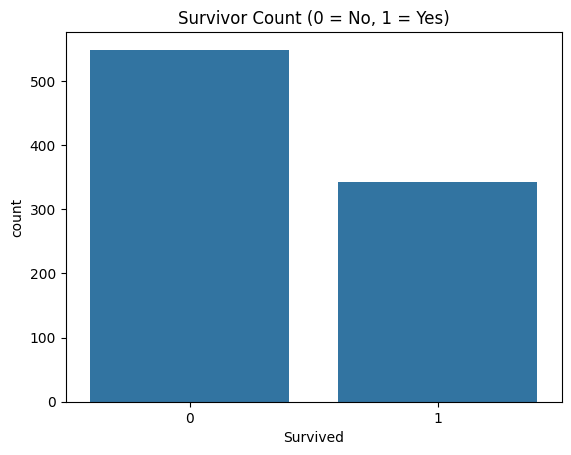

In [26]:
sns.countplot(data=train, x='Survived')
plt.title('Survivor Count (0 = No, 1 = Yes)')

Text(0.5, 1.0, 'Survival Count by Gender')

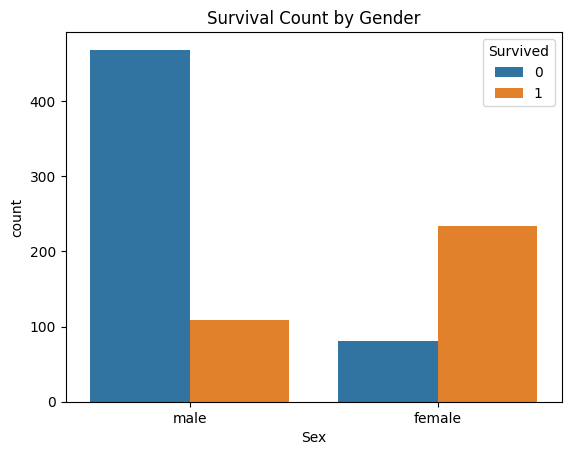

In [27]:
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Survival Count by Gender')

Text(0.5, 1.0, 'Age Distribution by Survival')

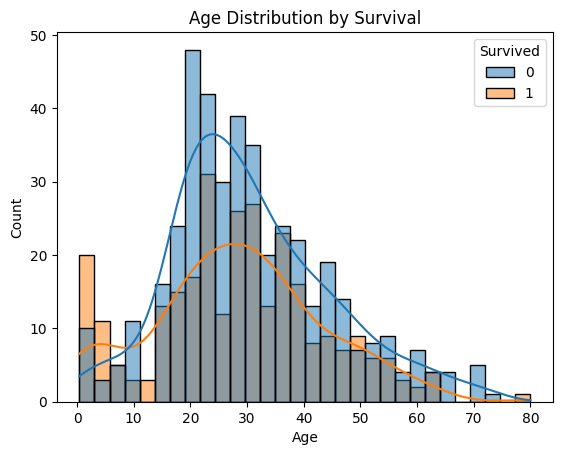

In [28]:
sns.histplot(data=train, x='Age', hue='Survived', bins=30, kde=True)
plt.title('Age Distribution by Survival')

# Preprocessing

In [29]:
train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [30]:
train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train = pd.get_dummies(train, columns=["Sex", "Embarked"], drop_first=True)
train.isnull().sum()

,0
Survived,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0
Sex_male,0
Embarked_Q,0
Embarked_S,0


# Feature Selection

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

X = train.drop("Survived", axis=1)
Y = train["Survived"]

selector = SelectKBest(score_func=f_classif, k=7)
X_selected = selector.fit_transform(X, Y)
selected_features = X.columns[selector.get_support()]

X = train[selected_features]

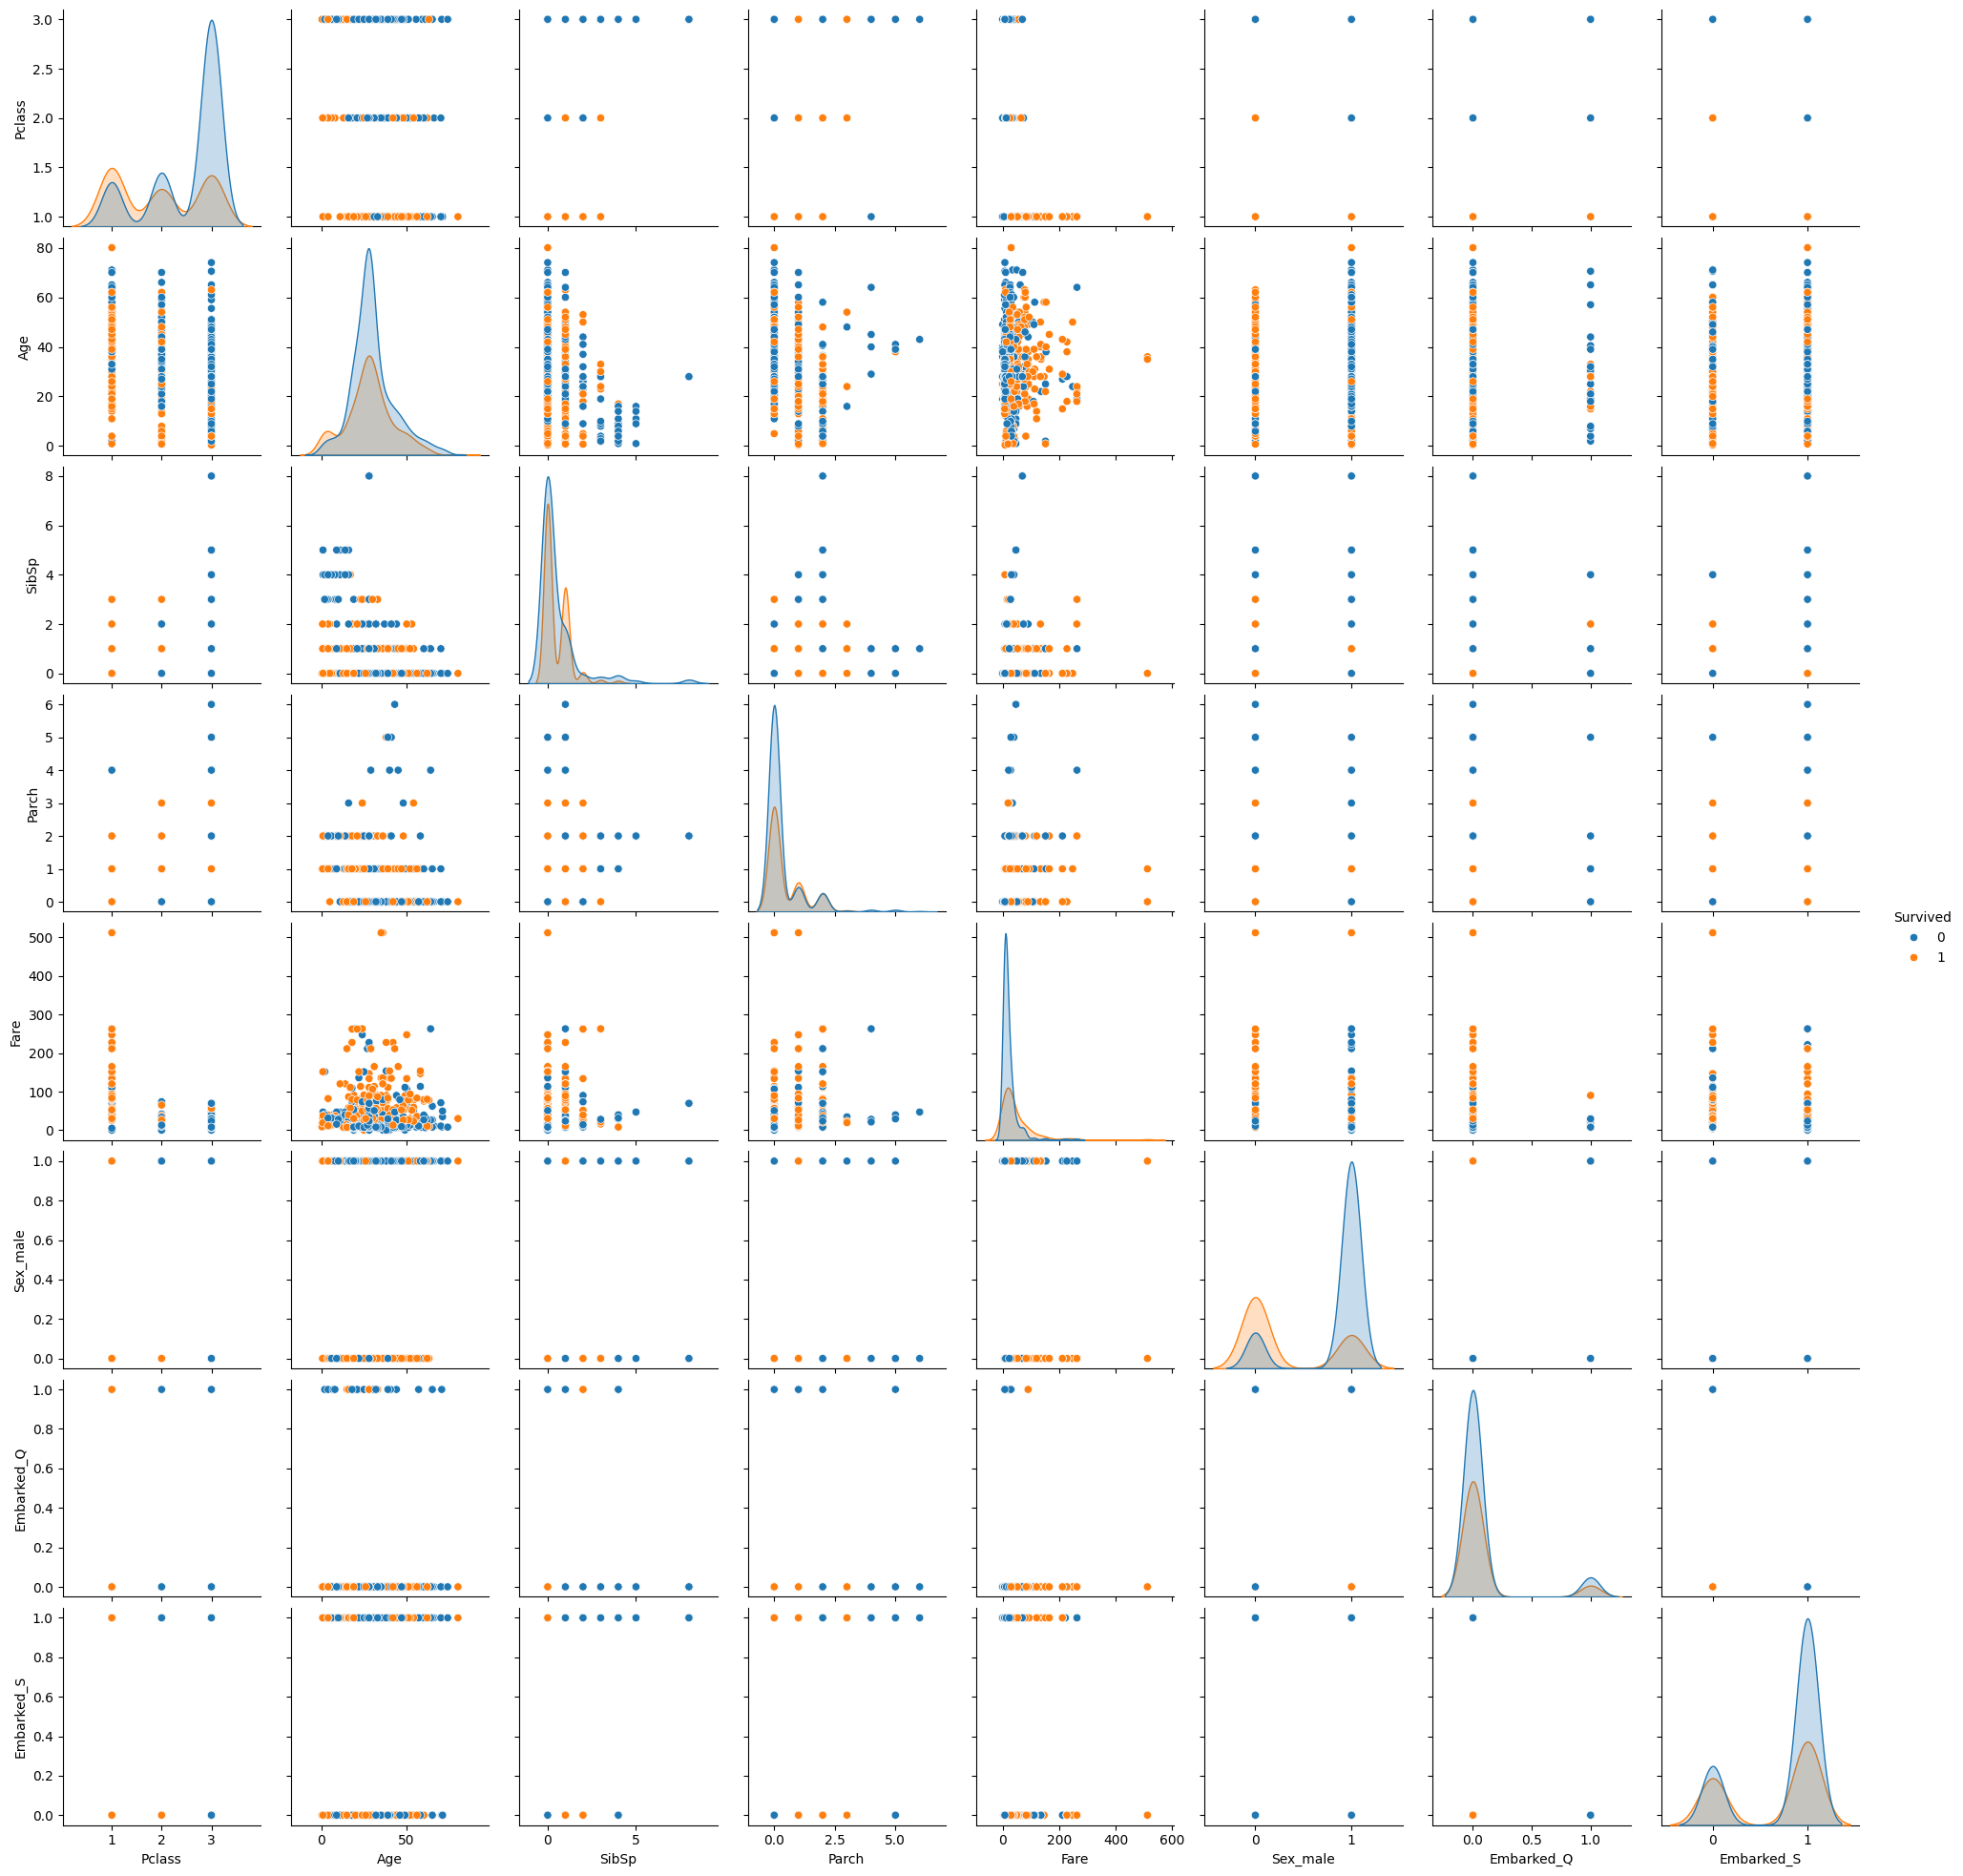

In [32]:
sns.pairplot(train, hue="Survived", diag_kind="kde")
plt.show()

# Класификациски модели со различни хиперпараметри

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

def evaluate_model(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    model_name = model.__class__.__name__
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.3f}")
    print(f"Precision: {precision_score(Y_test, Y_pred):.3f}")
    print(f"Recall: {recall_score(Y_test, Y_pred):.3f}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred):.3f}")

    #Confusion Matrix
    cfm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(pd.DataFrame(cfm), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    #Feature Importance
    if hasattr(model, "feature_importances_"):
        importance = pd.Series(model.feature_importances_, index=X.columns)
        importance.sort_values().plot(kind='barh', title=f"Feature Importance - {model_name}")
        plt.tight_layout()
        plt.show()

    #Coefficients (LogisticRegression, LDA)
    elif hasattr(model, "coef_"):
        coef = pd.Series(model.coef_[0], index=X.columns)
        coef.sort_values().plot(kind='barh', title=f"Feature Coefficients - {model_name}")
        plt.tight_layout()
        plt.show()

    #Naive Bayes Probability Heatmap
    elif "GaussianNB" in model_name and hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test[:20])
        sns.heatmap(probs, annot=True, cmap="YlGnBu")
        plt.title(f"Naive Bayes Probabilities - {model_name} (first 20 samples)")
        plt.xlabel("Class"); plt.ylabel("Sample Index")
        plt.tight_layout()
        plt.show()

    #LDA Projection
    elif model_name == "LinearDiscriminantAnalysis":
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_lda = lda.fit_transform(X_train, Y_train)
        df_lda = pd.DataFrame(X_lda, columns=["LD1", "LD2"])
        df_lda["Class"] = Y_train
        sns.scatterplot(data=df_lda, x="LD1", y="LD2", hue="Class", palette="Set1")
        plt.title(f"LDA Projection - {model_name}")
        plt.tight_layout()
        plt.show()

## Logistic Regression


--- LogisticRegression ---
Accuracy: 0.799
Precision: 0.771
Recall: 0.730
F1 Score: 0.750


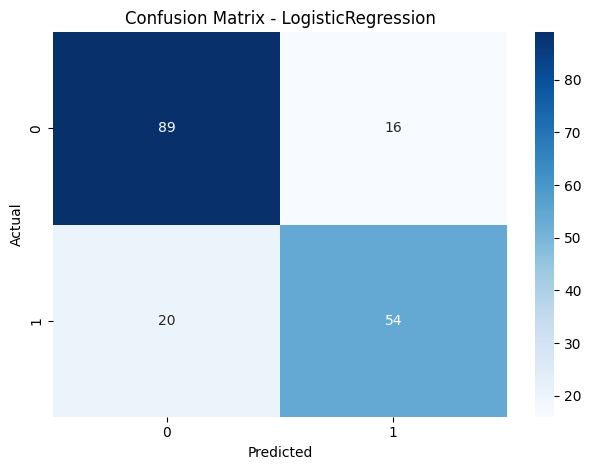

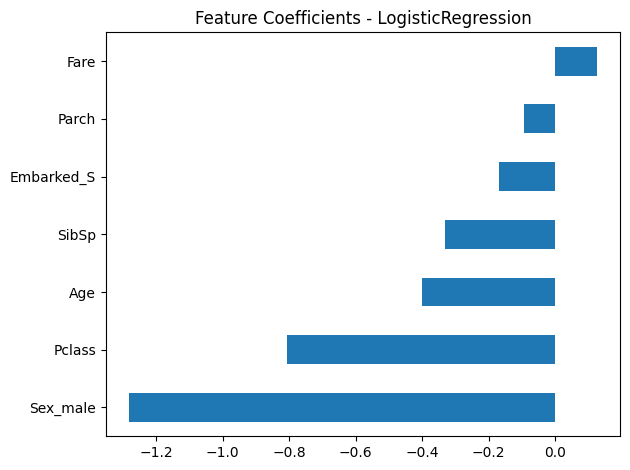

In [55]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(max_iter=1000))

## SVM (Support Vector Machine)


--- SVC ---
Accuracy: 0.821
Precision: 0.839
Recall: 0.703
F1 Score: 0.765


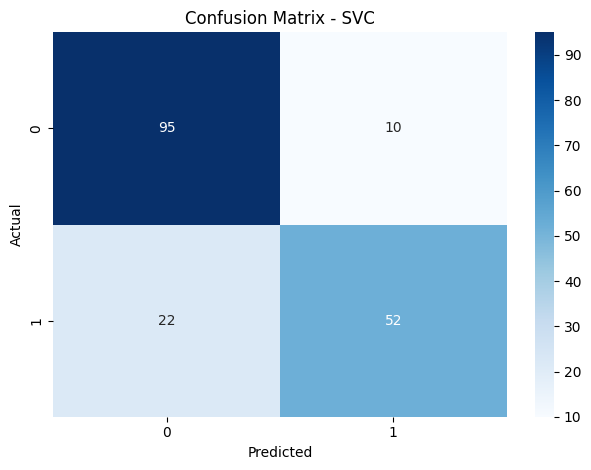

In [56]:
from sklearn.svm import SVC
evaluate_model(SVC(kernel='rbf', C=1))

## Random Forest Classifier


--- RandomForestClassifier ---
Accuracy: 0.816
Precision: 0.797
Recall: 0.743
F1 Score: 0.769


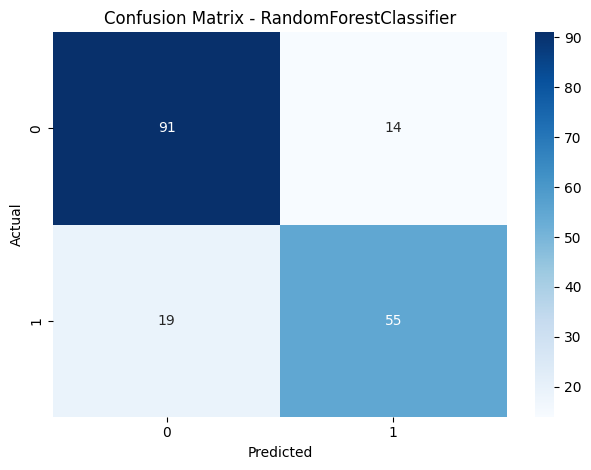

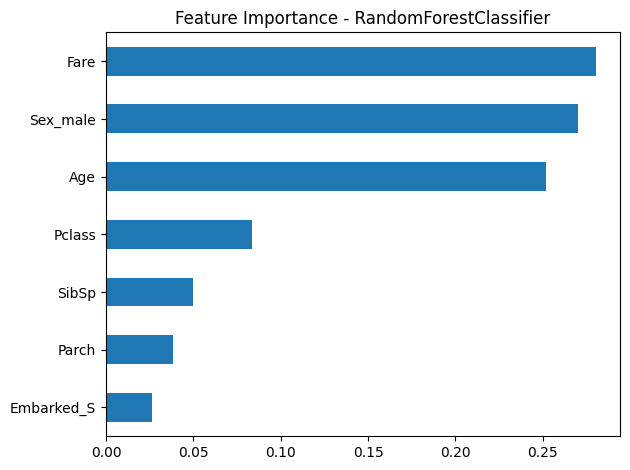

In [57]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42))

## KNN (K-Nearest Neighbors)


--- KNeighborsClassifier ---
Accuracy: 0.816
Precision: 0.797
Recall: 0.743
F1 Score: 0.769


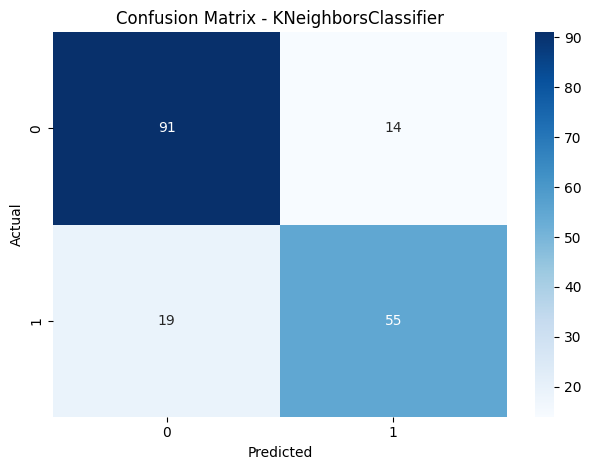

In [58]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_model(KNeighborsClassifier(n_neighbors=5))

## Naive Bayes


--- GaussianNB ---
Accuracy: 0.771
Precision: 0.720
Recall: 0.730
F1 Score: 0.725


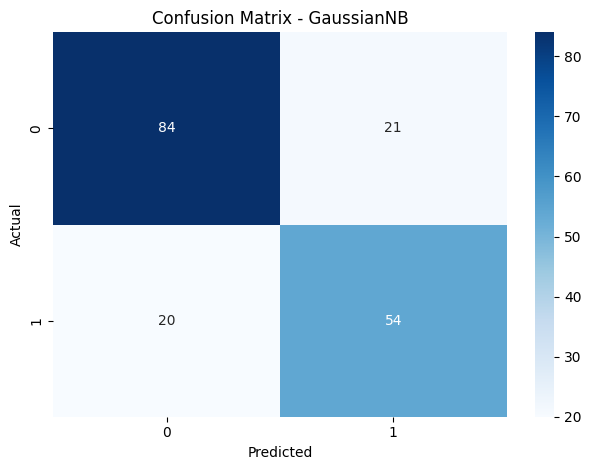

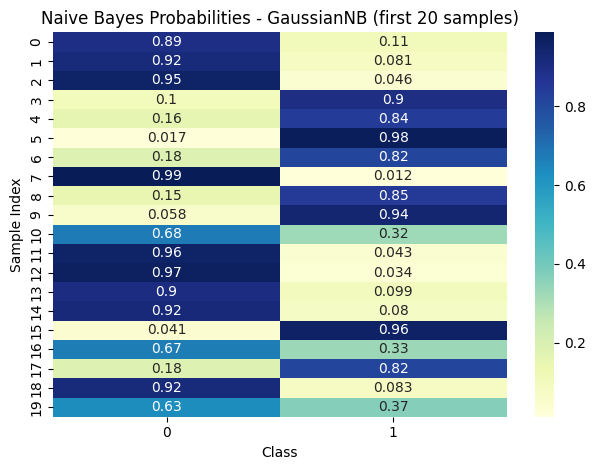

In [59]:
from sklearn.naive_bayes import GaussianNB
evaluate_model(GaussianNB())

## LDA / QDA


--- LinearDiscriminantAnalysis ---
Accuracy: 0.793
Precision: 0.768
Recall: 0.716
F1 Score: 0.741


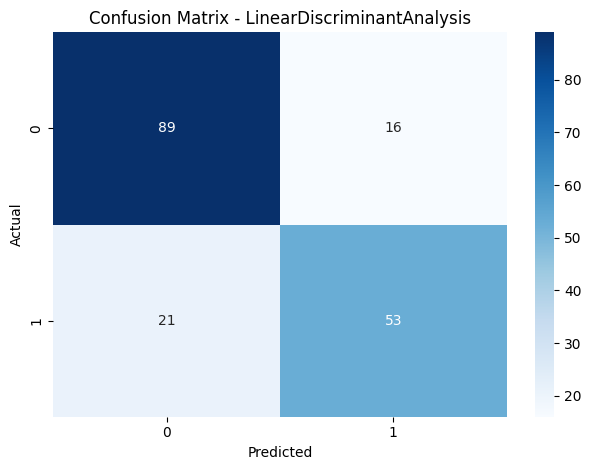

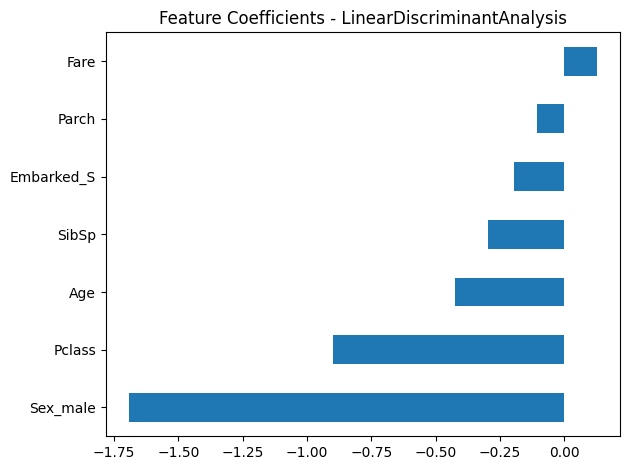


--- QuadraticDiscriminantAnalysis ---
Accuracy: 0.810
Precision: 0.794
Recall: 0.730
F1 Score: 0.761


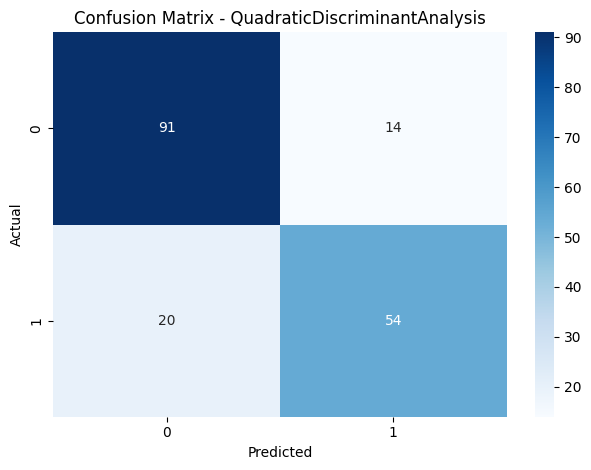

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
evaluate_model(LinearDiscriminantAnalysis())
evaluate_model(QuadraticDiscriminantAnalysis())

# Споредба на моделите

In [61]:
results_matrix = [
    ["Model",                     "Accuracy", "Precision", "Recall", "F1 Score"],
    ["Logistic Regression",       0.799,      0.771,       0.730,    0.750],
    ["SVM",                       0.821,      0.839,       0.703,    0.765],
    ["Random Forest",             0.816,      0.797,       0.743,    0.769],
    ["KNN",                       0.816,      0.797,       0.743,    0.769],
    ["Naive Bayes",               0.771,      0.720,       0.730,    0.725],
    ["LDA",                       0.793,      0.768,       0.716,    0.741],
    ["QDA",                       0.810,      0.794,       0.730,    0.761],
]
df = pd.DataFrame(results_matrix[1:], columns=results_matrix[0])
df.set_index("Model", inplace=True)
print(df)

                     Accuracy  Precision  Recall  F1 Score
Model                                                     
Logistic Regression     0.799      0.771   0.730     0.750
SVM                     0.821      0.839   0.703     0.765
Random Forest           0.816      0.797   0.743     0.769
KNN                     0.816      0.797   0.743     0.769
Naive Bayes             0.771      0.720   0.730     0.725
LDA                     0.793      0.768   0.716     0.741
QDA                     0.810      0.794   0.730     0.761


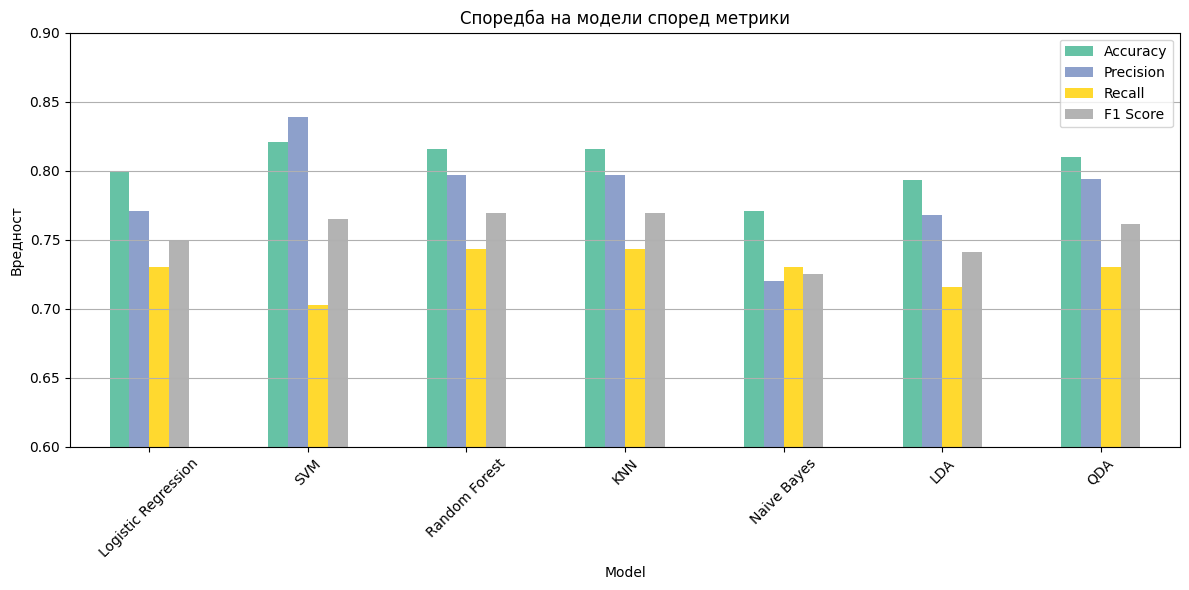

In [62]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
df[metrics].plot(kind='bar', figsize=(12, 6), colormap='Set2')

plt.title("Споредба на модели според метрики")
plt.ylabel("Вредност")
plt.ylim(0.6, 0.9)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Заклучок
Врз основа на споредбата на повеќе класификациски модели применети врз Titanic податочното множество, можеме да донесеме неколку важни заклучоци:
1. Највисока точност (Accuracy) постигна SVM моделот (0.821), што укажува на добра генерализација на нови податоци.
2. Највисока прецизност (Precision) исто така имаше SVM (0.839), што е особено важно кога сакаме да избегнеме лажни позитивни предвидувања.
3. Највисока чувствителност (Recall) имаат Random Forest, kNN и Naive Bayes (0.743), што значи дека тие модели подобро ги детектираат позитивните случаи (преживеани патници).
4. F1 скорот, кој е балансирана метрика помеѓу Precision и Recall, е највисок кај Random Forest (0.769) и многу блиску до него се kNN, Naive Bayes и SVM.

Иако SVM има највисока точност и прецизност, Random Forest и kNN имаат поконзистентни резултати низ сите метрики.

За Titanic класификацискиот проблем:
* SVM е најдобар избор ако прецизноста е клучна.
* Random Forest или kNN се одлични избори за балансирани резултати.
* Naive Bayes се покажа изненадувачки добро со минимална комплексност и брза извршност.